In [3]:
!pip install plotly
!pip install Lifetimes
!pip install nb_black

     |████████████████████████████████| 584 kB 3.7 MB/s eta 0:00:01
  Created wheel for nb-black: filename=nb_black-1.0.7-py3-none-any.whl size=5279 sha256=c2cedaef1fe81eedf24d0190e63d737d50306e3f1c4cad7dce4951cc7e8df595
  Stored in directory: /root/.cache/pip/wheels/1e/b2/88/51c66d23ea5fd0d40ed50997555e15d981d92671376a9a412a
Successfully built nb-black


In [4]:
import os
import datetime
import squarify
import warnings
import pandas as pd 
import numpy as np
import datetime as dt
from operator import attrgetter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
%matplotlib inline
%load_ext nb_black
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
palette = 'Set2'

<IPython.core.display.Javascript object>

<a id = "2"></a>
<span style=" font-family:Verdana; font-size:190%; color:#31A919; ">Load and Check Data</span>

In [5]:
ecommerce_path = '/kaggle/input/ecommerce-data/'

df = pd.read_csv(os.path.join(ecommerce_path, 'data.csv'),
                 header = 0,
                 encoding = 'unicode_escape',
                 dtype = {'CustomerID': str,
                          'InvoiceID': str},
                 parse_dates = ['InvoiceDate'], 
                 infer_datetime_format = True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


<IPython.core.display.Javascript object>

<a id = "3"></a>
<span style=" font-family:Verdana; font-size:190%; color:#31A919; ">Understanding Data</span>

<span style="color:#31A919;
             font-size:160%;
             font-family:Verdana;">
📃 Variable Description
    
- **InvoiceNo:** Invoice number that consists 6 digits. If this code starts with letter 'c', it indicates a cancellation.
- **StockCode:** Product code that consists 5 digits.
- **Description:** Product name.
- **Quantity:** The quantities of each product per transaction.
- **InvoiceDate:** Represents the day and time when each transaction was generated.
- **UnitPrice:** Product price per unit.
- **CustomerID:** Customer number that consists 5 digits. Each customer has a unique customer ID.
- **Country:** Name of the country where each customer resides.

In [6]:
def check_data(dataframe, head=5):
    print(" SHAPE ".center(70,'-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70,'-'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'-'))
    print(dataframe.head(head))
    print(" TAIL ".center(70,'-'))
    print(dataframe.tail(head))
    print(" MISSING VALUES ".center(70,'-'))
    print(dataframe.isnull().sum())
    print(" DUPLICATED VALUES ".center(70,'-'))
    print(dataframe.duplicated().sum())
    print(" QUANTILES ".center(70,'-'))
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
check_data(df)

------------------------------- SHAPE --------------------------------
Rows: 541909
Columns: 8
------------------------------- TYPES --------------------------------
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object
-------------------------------- HEAD --------------------------------
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 0

<IPython.core.display.Javascript object>

In [7]:
# Group by product to get total sales per product
product_sales = df.groupby(['StockCode', 'Description'])['Quantity'].sum().reset_index()

# Most sold product
most_sold_product = product_sales.loc[product_sales['Quantity'].idxmax()]
print("Most Sold Product:")
print(most_sold_product)

# Least sold product
least_sold_product = product_sales.loc[product_sales['Quantity'].idxmin()]
print("\nLeast Sold Product:")
print(least_sold_product)

Most Sold Product:
StockCode                                  84077
Description    WORLD WAR 2 GLIDERS ASSTD DESIGNS
Quantity                                   53847
Name: 3617, dtype: object

Least Sold Product:
StockCode                             23005
Description    printing smudges/thrown away
Quantity                             -19200
Name: 2235, dtype: object


<IPython.core.display.Javascript object>

In [8]:
# Sort products by quantity sold
top_products = product_sales.sort_values(by='Quantity', ascending=False).head(5)
bottom_products = product_sales.sort_values(by='Quantity', ascending=True).head(5)

print("\nTop 5 Products by Sales Volume:")
print(top_products)

print("\nBottom 5 Products by Sales Volume:")
print(bottom_products)


Top 5 Products by Sales Volume:
     StockCode                        Description  Quantity
3617     84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS     53847
4197    85099B            JUMBO BAG RED RETROSPOT     47363
3956     84879      ASSORTED COLOUR BIRD ORNAMENT     36381
1333     22197                     POPCORN HOLDER     36334
531      21212    PACK OF 72 RETROSPOT CAKE CASES     36039

Bottom 5 Products by Sales Volume:
     StockCode                   Description  Quantity
2235     23005  printing smudges/thrown away    -19200
2231     23003  Printing smudges/thrown away     -9058
3399    72140F                    throw away     -5368
3534    79323W        Unsaleable, destroyed.     -4830
203      20713  wrongly marked. 23343 in box     -3100


<IPython.core.display.Javascript object>

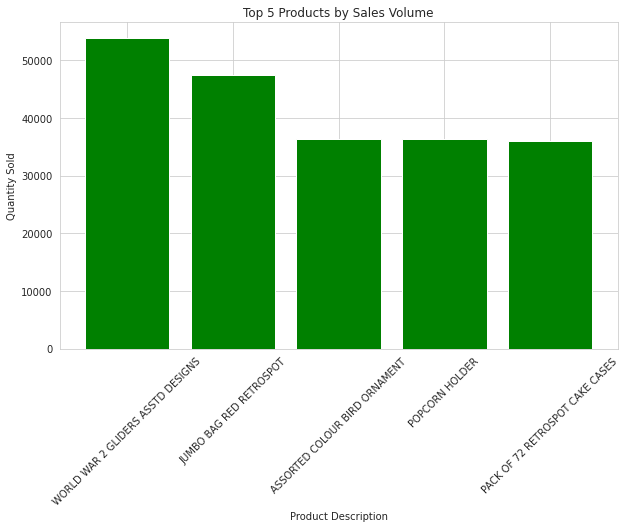

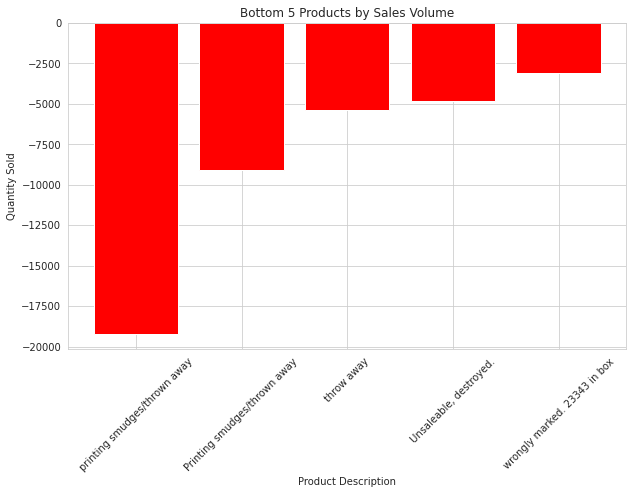

<IPython.core.display.Javascript object>

In [9]:
import matplotlib.pyplot as plt

# Plot top 5 products
plt.figure(figsize=(10, 6))
plt.bar(top_products['Description'], top_products['Quantity'], color='green')
plt.title("Top 5 Products by Sales Volume")
plt.xlabel("Product Description")
plt.ylabel("Quantity Sold")
plt.xticks(rotation=45)
plt.show()

# Plot bottom 5 products
plt.figure(figsize=(10, 6))
plt.bar(bottom_products['Description'], bottom_products['Quantity'], color='red')
plt.title("Bottom 5 Products by Sales Volume")
plt.xlabel("Product Description")
plt.ylabel("Quantity Sold")
plt.xticks(rotation=45)
plt.show()


In [10]:
# Calculate the number of unique customers for each product
customer_favorites = df.groupby(['StockCode', 'Description'])['CustomerID'].nunique().reset_index(name='unique_customers')

# Most popular product by customer count
most_popular_product = customer_favorites.loc[customer_favorites['unique_customers'].idxmax()]
print("\nMost Popular Product by Customer Count:")
print(most_popular_product)


Most Popular Product by Customer Count:
StockCode                              22423
Description         REGENCY CAKESTAND 3 TIER
unique_customers                         887
Name: 1554, dtype: object


<IPython.core.display.Javascript object>

In [5]:
world_map = df[['CustomerID', 'InvoiceNo', 'Country']
              ].groupby(['CustomerID', 'InvoiceNo', 'Country']
                       ).count().reset_index(drop = False)
countries = world_map['Country'].value_counts()
data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names',
            z = countries,
            text = countries.index,
            colorbar = {'title':'Orders'},
            colorscale='Viridis',
            reversescale = False)

layout = dict(title={'text': "Number of Orders by Countries",
                     'y':0.9,
                     'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'},
              geo = dict(resolution = 50,
                         showocean = True,
                         oceancolor = "LightBlue",
                         showland = True,
                         landcolor = "whitesmoke",
                         showframe = True),
             template = 'plotly_white',
             height = 600,
             width = 1000)

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate = False)

<IPython.core.display.Javascript object>

<span style="color:#31A919;
             font-size:160%;
             font-family:Verdana;">
Descriptive Statistics

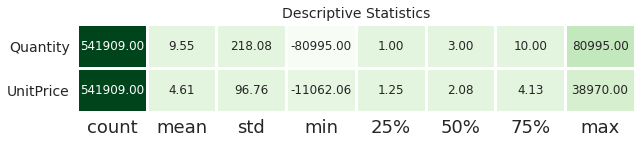

<IPython.core.display.Javascript object>

In [6]:
def desc_stats(dataframe):
    desc_df = pd.DataFrame(index= dataframe.columns, 
                           columns= dataframe.describe().T.columns,
                           data= dataframe.describe().T)
    
    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0] * 0.81))
    sns.heatmap(desc_df,
                annot = True,
                cmap = "Greens",
                fmt = '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.1,
                cbar = False,
                annot_kws = {"size": 12})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
    
desc_stats(df.select_dtypes(include = [float, int]))

📌  It is clearly seems that there are ouliters in Quantity and UnitPrice that have to be handled <br />
📌  There are negative values in UnitPrice and Quantity because of **cancelled orders**. <br /> 
📌  Missing values in Customer ID and Description. <br />
📌  Quantity and Unit Price should be multiplied in order to create **Total Price**.               


<a id = "4"></a>
<span style=" font-family:Verdana; font-size:190%; color:#31A919; ">Data Preprocessing</span>

In [7]:
def replace_with_thresholds(dataframe, variable, q1 = 0.25, q3 = 0.75):
    
    '''
    Detects outliers with IQR method and replaces with thresholds 
    
    '''
    
    df_ = dataframe.copy()
    quartile1 = df_[variable].quantile(q1)
    quartile3 = df_[variable].quantile(q3)
    iqr = quartile3 - quartile1
    
    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    df_.loc[(df_[variable] < low_limit), variable] = low_limit
    df_.loc[(df_[variable] > up_limit), variable] = up_limit
    
    return df_

def ecommerce_preprocess(dataframe):
    df_ = dataframe.copy()
    
    #Missing Values
    df_ = df_.dropna()
    
    #Cancelled Orders & Quantity
    df_ = df_[~df_['InvoiceNo'].str.contains('C', na = False)]
    df_ = df_[df_['Quantity'] > 0]
    
    #Replacing Outliers
    df_ = replace_with_thresholds(df_, "Quantity", q1 = 0.01, q3 = 0.99)
    df_ = replace_with_thresholds(df_, "UnitPrice", q1 = 0.01, q3 = 0.99)
    
    #Total Price
    df_["TotalPrice"] = df_["Quantity"] * df_["UnitPrice"]
    
    return df_

<IPython.core.display.Javascript object>

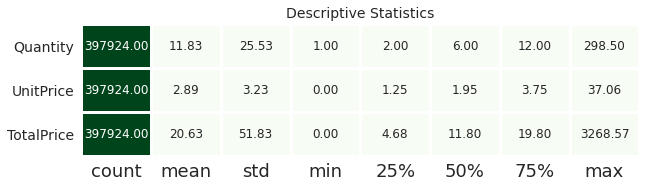

<IPython.core.display.Javascript object>

In [8]:
df = ecommerce_preprocess(df)

desc_stats(df.select_dtypes(include = [float, int]))

<a id = "5"></a>
<span style=" font-family:Verdana; font-size:190%; color:#31A919; ">RFM Analysis</span>

RFM stands for **Recency**, **Frequency**, and **Monetary** value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.   

RFM factors illustrate these facts:

- The more recent the purchase, the more responsive the customer is to promotions
- The more frequently the customer buys, the more engaged and satisfied they are
- Monetary value differentiates heavy spenders from low-value purchasers

<span style="color:#31A919;
             font-size:160%;
             font-family:Verdana;">
RFM Metrics

In [9]:
print(df['InvoiceDate'].max())

2011-12-09 12:50:00


<IPython.core.display.Javascript object>

In [10]:
today_date = dt.datetime(2011,12,11)

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (today_date - x.max()).days,
                                    'InvoiceNo': lambda x: x.nunique(),
                                    'TotalPrice': lambda x: x.sum()})

rfm.columns = ['recency', 'frequency', 'monetary']
rfm['monetary'] = rfm[rfm['monetary'] > 0]
rfm = rfm.reset_index()

rfm.head()

,CustomerID,recency,frequency,monetary
0,12346,326,1,326.0
1,12347,3,7,3.0
2,12348,76,4,76.0
3,12349,19,1,19.0
4,12350,311,1,311.0


<IPython.core.display.Javascript object>

<span style="color:#31A919;
             font-size:160%;
             font-family:Verdana;">
RFM Scores

In [11]:
def get_rfm_scores(dataframe) -> pd.core.frame.DataFrame:

    df_ = dataframe.copy()
    df_["recency_score"] = pd.qcut(df_["recency"], 5, labels=[5, 4, 3, 2, 1])
    df_["frequency_score"] = pd.qcut(
        df_["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5]
    )
    df_["monetary_score"] = pd.qcut(df_["monetary"], 5, labels=[1, 2, 3, 4, 5])
    df_["RFM_SCORE"] = df_["recency_score"].astype(str) + df_["frequency_score"].astype(
        str
    )

    return df_


rfm = get_rfm_scores(rfm)

<IPython.core.display.Javascript object>

<span style="color:#31A919;
             font-size:160%;
             font-family:Verdana;">
Segmentation

In [12]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)

rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346,326,1,326.0,1,1,5,11,hibernating
1,12347,3,7,3.0,5,5,1,55,champions
2,12348,76,4,76.0,2,4,4,24,at_Risk
3,12349,19,1,19.0,4,1,2,41,promising
4,12350,311,1,311.0,1,1,5,11,hibernating


<IPython.core.display.Javascript object>

<span style="color:#31A919;
             font-size:160%;
             font-family:Verdana;">
Segmentation Map

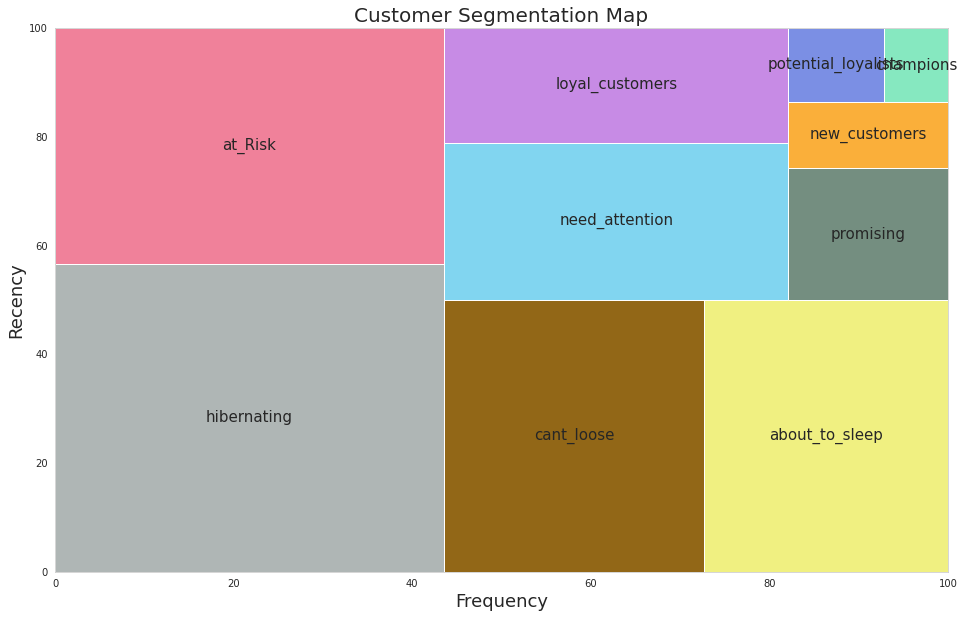

<IPython.core.display.Javascript object>

In [13]:
segments = rfm["segment"].value_counts().sort_values(ascending=False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(
    sizes=segments,
    label=[label for label in seg_map.values()],
    color=[
        "#AFB6B5",
        "#F0819A",
        "#926717",
        "#F0F081",
        "#81D5F0",
        "#C78BE5",
        "#748E80",
        "#FAAF3A",
        "#7B8FE4",
        "#86E8C0",
    ],
    pad=False,
    bar_kwargs={"alpha": 1},
    text_kwargs={"fontsize": 15},
)
plt.title("Customer Segmentation Map", fontsize=20)
plt.xlabel("Frequency", fontsize=18)
plt.ylabel("Recency", fontsize=18)
plt.show()

<span style="color:#31A919;
             font-size:160%;
             font-family:Verdana;">
Model Evaluation

In [14]:
print(' RFM Model Evaluation '.center(70, '='))
X = rfm[['recency_score', 'frequency_score']]
labels = rfm['segment']
print(f'Number of Observations: {X.shape[0]}')
print(f'Number of Segments: {labels.nunique()}')
print(f'Silhouette Score: {round(silhouette_score(X, labels), 3)}')
print(f'Calinski Harabasz Score: {round(calinski_harabasz_score(X, labels), 3)}')
print(f'Davies Bouldin Score: {round(davies_bouldin_score(X, labels), 3)} \n{70*"="}')

======================== RFM Model Evaluation ========================
Number of Observations: 4339
Number of Segments: 10
Silhouette Score: 0.471
Calinski Harabasz Score: 4591.503
Davies Bouldin Score: 0.633 


<IPython.core.display.Javascript object>

<span style="color:#31A919;
             font-size:160%;
             font-family:Verdana;">
Segment Analysis

In [15]:
rfm[['recency','monetary','frequency','segment']]\
.groupby('segment')\
.agg({'mean','std','max','min'})

recency                        monetary               \
                           mean  max min        std        mean    max   min   
segment                                                                        
about_to_sleep        53.312500   72  34  10.943474   53.312500   72.0  34.0   
at_Risk              153.785835  374  73  68.618828  153.785835  374.0  73.0   
cant_loose           132.968254  373  73  65.250378  132.968254  373.0  73.0   
champions              6.361769   13   1   3.683300    6.361769   13.0   1.0   
hibernating          217.605042  374  73  92.013560  217.605042  374.0  73.0   
loyal_customers       33.608059   72  15  15.577050   33.608059   72.0  15.0   
need_attention        52.427807   72  34  11.552074   52.427807   72.0  34.0   
new_customers          7.428571   13   1   3.902112    7.428571   13.0   1.0   
potential_loyalists   17.398760   33   1   9.338808   17.398760   33.0   1.0   
promising             23.421053   33  15   5.238115   23.510638   33.0  15.0   

                                frequency                      
                           std       mean  max min        std  
segment                                                        
about_to_sleep       10.943474   1.161932    2   1   0.368913  
at_Risk              68.618828   2.878583    6   2   0.954415  
cant_loose           65.250378   8.380952   34   6   4.289630  
champions             3.683300  12.417062  210   3  16.476484  
hibernating          92.013560   1.101774    2   1   0.302492  
loyal_customers      15.577050   6.479853   63   3   4.545669  
need_attention       11.552074   2.326203    3   2   0.470081  
new_customers         3.902112   1.000000    1   1   0.000000  
potential_loyalists   9.338808   2.010331    3   1   0.651401  
promising             5.192519   1.000000    1   1   0.000000

<IPython.core.display.Javascript object>

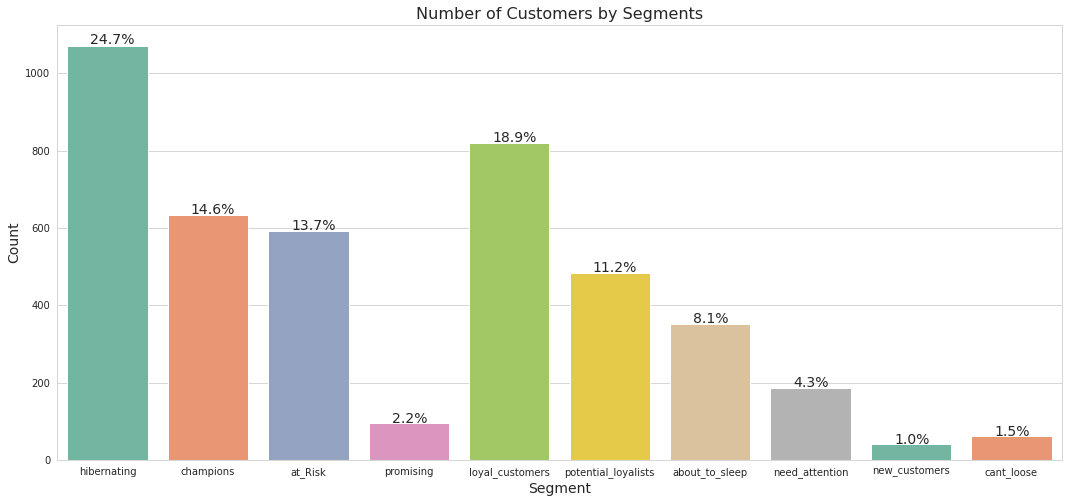

<IPython.core.display.Javascript object>

In [16]:
plt.figure(figsize = (18, 8))
ax = sns.countplot(data = rfm,
                   x = 'segment',
                   palette = palette)
total = len(rfm.segment)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 14)
plt.title('Number of Customers by Segments', size = 16)
plt.xlabel('Segment', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()

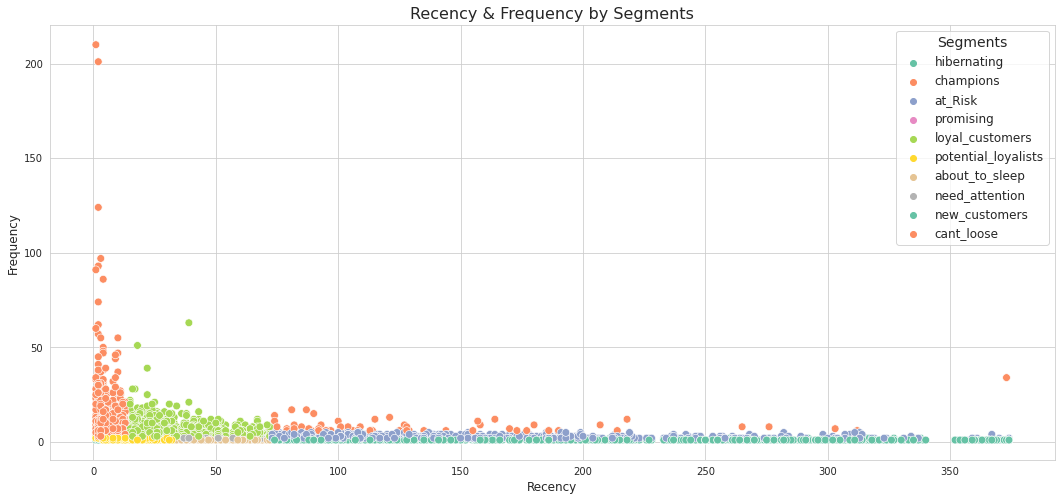

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(18, 8))
sns.scatterplot(
    data=rfm, x="recency", y="frequency", hue="segment", palette=palette, s=60
)
plt.title("Recency & Frequency by Segments", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("Frequency", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Segments", title_fontsize=14)
plt.show()

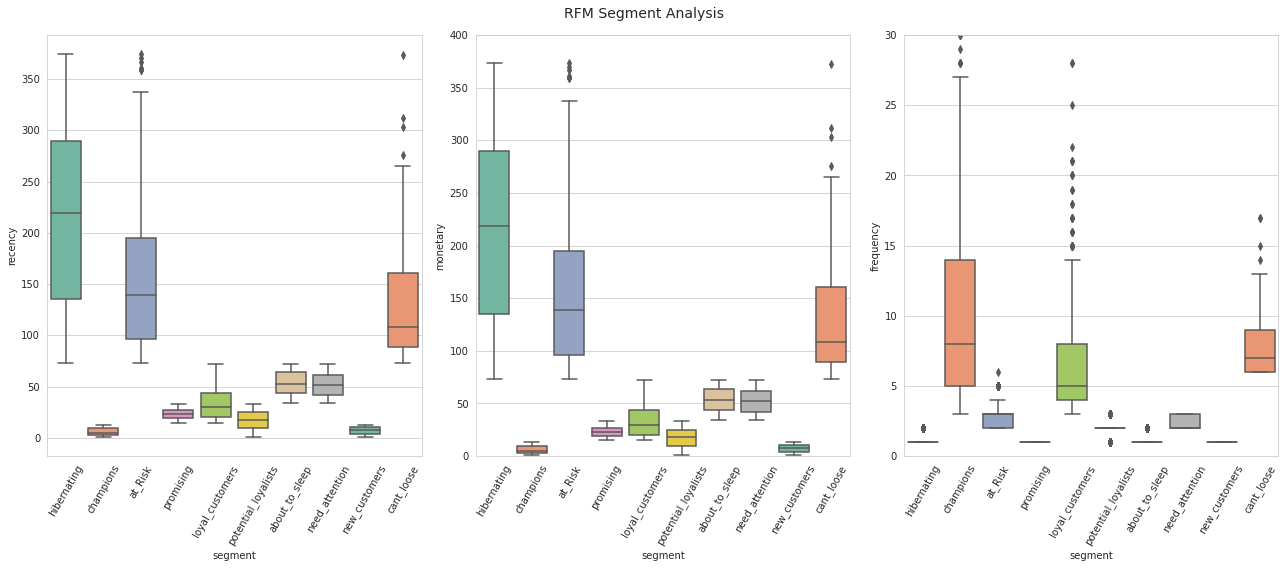

<IPython.core.display.Javascript object>

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
fig.suptitle("RFM Segment Analysis", size=14)
feature_list = ["recency", "monetary", "frequency"]
for idx, col in enumerate(feature_list):
    sns.boxplot(
        ax=axes[idx], data=rfm, x="segment", y=feature_list[idx], palette=palette
    )
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=60)
    if idx == 1:
        axes[idx].set_ylim([0, 400])
    if idx == 2:
        axes[idx].set_ylim([0, 30])
plt.tight_layout()
plt.show()

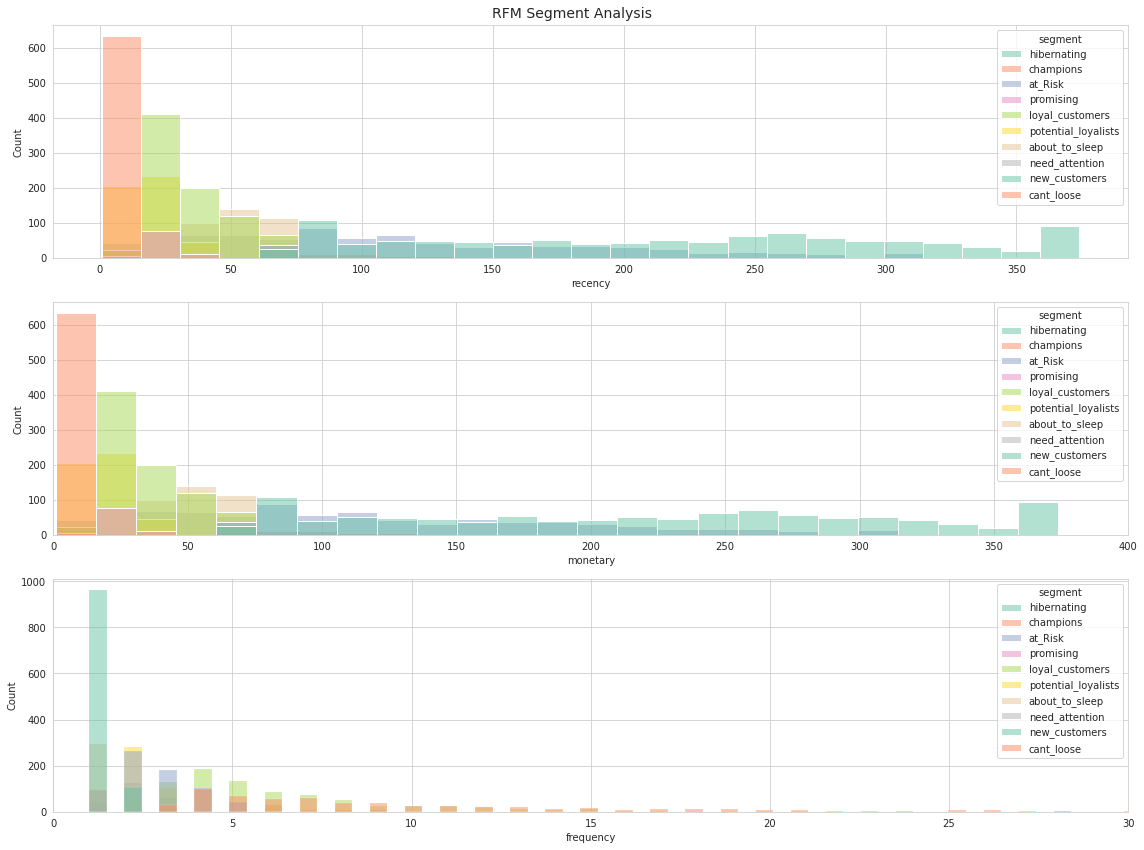

<IPython.core.display.Javascript object>

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('RFM Segment Analysis', size = 14)
feature_list = ['recency', 'monetary', 'frequency']
for idx, col in enumerate(feature_list):
    sns.histplot(ax = axes[idx], data = rfm,
                 hue = 'segment', x = feature_list[idx],
                 palette= palette)
    if idx == 1:
        axes[idx].set_xlim([0, 400])
    if idx == 2:
        axes[idx].set_xlim([0, 30])
plt.tight_layout()
plt.show()

<a id = "6"></a>
<span style=" font-family:Verdana; font-size:190%; color:#31A919; ">Cohort Analysis</span>

A cohort is a group of people sharing something in common, such as the sign-up date to an app, the month of the first purchase, geographical location, acquisition channel (organic users, coming from performance marketing, etc.) and so on. In Cohort Analysis, we track these groups of users over time, to identify some common patterns or behaviors.

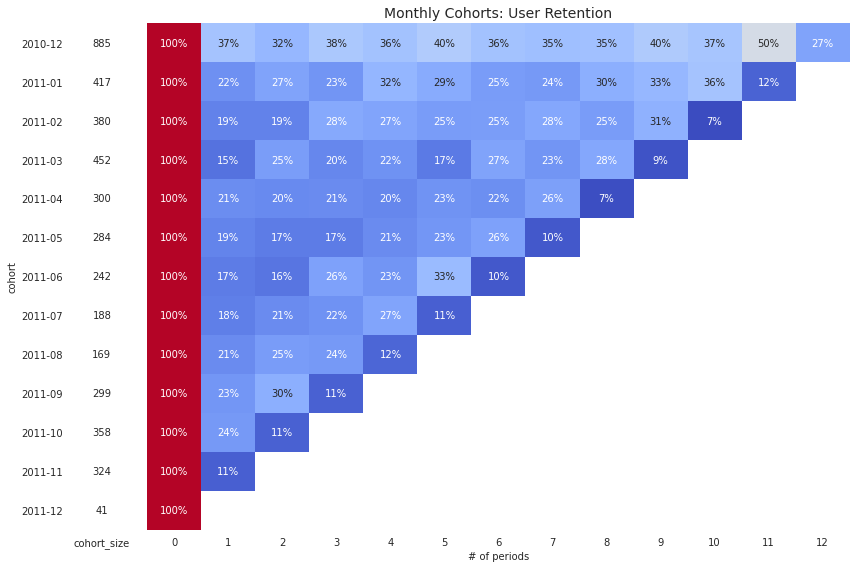

<IPython.core.display.Javascript object>

In [20]:
def CohortAnalysis(dataframe):

    data = dataframe.copy()
    data = data[["CustomerID", "InvoiceNo", "InvoiceDate"]].drop_duplicates()
    data["order_month"] = data["InvoiceDate"].dt.to_period("M")
    data["cohort"] = (
        data.groupby("CustomerID")["InvoiceDate"].transform("min").dt.to_period("M")
    )
    cohort_data = (
        data.groupby(["cohort", "order_month"])
        .agg(n_customers=("CustomerID", "nunique"))
        .reset_index(drop=False)
    )
    cohort_data["period_number"] = (cohort_data.order_month - cohort_data.cohort).apply(
        attrgetter("n")
    )
    cohort_pivot = cohort_data.pivot_table(
        index="cohort", columns="period_number", values="n_customers"
    )
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(
            1, 2, figsize=(12, 8), sharey=True, gridspec_kw={"width_ratios": [1, 11]}
        )
        sns.heatmap(
            retention_matrix,
            mask=retention_matrix.isnull(),
            annot=True,
            cbar=False,
            fmt=".0%",
            cmap="coolwarm",
            ax=ax[1],
        )
        ax[1].set_title("Monthly Cohorts: User Retention", fontsize=14)
        ax[1].set(xlabel="# of periods", ylabel="")
        white_cmap = mcolors.ListedColormap(["white"])
        sns.heatmap(
            pd.DataFrame(cohort_size).rename(columns={0: "cohort_size"}),
            annot=True,
            cbar=False,
            fmt="g",
            cmap=white_cmap,
            ax=ax[0],
        )
        fig.tight_layout()
    
CohortAnalysis(df)

<a id = "7"></a>
<span style=" font-family:Verdana; font-size:190%; color:#31A919; ">Customer Lifetime Value</span>

Customer lifetime value is how much money a customer will bring your brand throughout their entire time as a paying customer.

In [21]:
cltv_df = df.groupby("CustomerID").agg(
    {
        "InvoiceDate": [
            lambda x: (x.max() - x.min()).days,
            lambda x: (today_date - x.min()).days,
        ],
        "InvoiceNo": "nunique",
        "TotalPrice": "sum",
    }
)

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ["recency", "T", "frequency", "monetary"]
cltv_df.head()

,recency,T,frequency,monetary
CustomerID,,,,
12346,0,326,1,310.44
12347,365,368,7,4310.00
12348,282,359,4,1770.78
12349,0,19,1,1491.72
12350,0,311,1,331.46


<IPython.core.display.Javascript object>

In [22]:
#Average Order Value
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

#Recency & Tenure
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

#Frequency
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

<IPython.core.display.Javascript object>

<span style="color:#31A919;
             font-size:160%;
             font-family:Verdana;">
BG/NBD
    
Beta Geometric / Negative Binomial Distribution models assume that the number of transactions made by each customer follows a Poisson process with a heterogeneity in transaction rates across customers following a **gamma distribution**. These assumptions give us a Negative binomial distribution (NBD) for modeling the number of transactions made by the customer while he is alive. We can build BG/NBD model by using <code>BetaGeoFitter</code> and <code>lifetimes</code> packages.

In [23]:
BGF = BetaGeoFitter(penalizer_coef=0.001)  # avoid overfitting

BGF.fit(cltv_df["frequency"], cltv_df["recency"], cltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.40, b: 2.49, r: 2.18>

<IPython.core.display.Javascript object>

<span style="color:#31A919;
             font-size:160%;
             font-family:Verdana;">
Top 10 Expected Number of Transaction (1 Week)

In [24]:
BGF.conditional_expected_number_of_purchases_up_to_time(
    1, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"]
).sort_values(ascending=False).head(10).to_frame(
    "Expected Number of Transactions"
).reset_index()

,CustomerID,Expected Number of Transactions
0,12748,3.265158
1,14911,3.126645
2,17841,1.940290
3,13089,1.537528
4,14606,1.463999
5,15311,1.433717
6,12971,1.357024
7,14646,1.222517
8,13408,0.986249
9,18102,0.968607


<IPython.core.display.Javascript object>

<span style="color:#31A919;
             font-size:160%;
             font-family:Verdana;">
Top 10 Expected Number of Transaction (1 Month)

In [25]:
BGF.conditional_expected_number_of_purchases_up_to_time(
    4, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"]
).sort_values(ascending=False).head(10).to_frame(
    "Expected Number of Transactions"
).reset_index()

,CustomerID,Expected Number of Transactions
0,12748,13.025670
1,14911,12.473095
2,17841,7.740345
3,13089,6.133456
4,14606,5.840269
5,15311,5.719467
6,12971,5.413481
7,14646,4.876360
8,13408,3.934373
9,18102,3.863856


<IPython.core.display.Javascript object>

<span style="color:#31A919;
             font-size:160%;
             font-family:Verdana;">
Frequency of Repeat Transactions

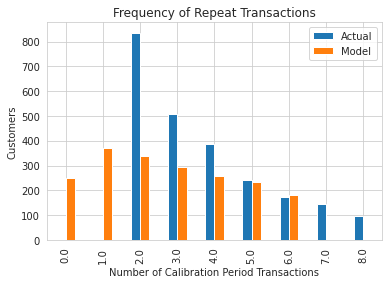

<IPython.core.display.Javascript object>

In [26]:
# Plot a figure with period actual and predicted transactions.
plot_period_transactions(BGF, max_frequency=7)
plt.show()